# Задача

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# План работы

1. Провести обзор и общую подготовку данных (проверить типы и содержимое, исправить данные при необходимости, провести работу над пропусками)
2. Исследовать данные (посмотреть зависимости, вузализация данных, предварительные выводы)
3. Окончательная подготовка данных для моделей (балансировка, исключение признаков, скалирование, OHE)
4. Работа с моделями и подбор параметров (в т.ч. оптимизация для лучшего решения)
5. Выбор итоговой модели и вывод

In [1]:
# блок импорта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Подготовка моделей
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Метрики
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# CatBoost
from catboost import CatBoostClassifier, Pool, cv

RANDOM_STATE = 42

In [2]:
import random
    
def init_random(state):
    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)

init_random(RANDOM_STATE)

## Обзор данных и их подготовка

In [3]:
# Загрузим данные
contract = pd.read_csv('data/contract.csv')
internet = pd.read_csv('data/internet.csv')
personal = pd.read_csv('data/personal.csv')
phone = pd.read_csv('data/phone.csv')

In [4]:
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
185,1024-GUALD,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,24.80,24.8
2715,0484-JPBRU,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45
3825,3620-EHIMZ,2015-10-01,No,Two year,No,Mailed check,19.35,1031.7
1807,6910-HADCM,2019-09-01,2019-10-01 00:00:00,Month-to-month,No,Electronic check,76.35,76.35
132,8587-XYZSF,2014-07-01,No,Two year,No,Bank transfer (automatic),50.55,3260.1


In [5]:
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
811,3748-FVMZZ,DSL,No,No,No,Yes,No,Yes
2065,5028-GZLDO,Fiber optic,No,No,No,No,No,No
5030,0254-WWRKD,DSL,No,Yes,No,No,No,No
4974,2869-ADAWR,Fiber optic,No,Yes,No,No,Yes,No
4346,9572-MTILT,Fiber optic,Yes,Yes,Yes,Yes,Yes,No


In [6]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
451,5760-WRAHC,Female,1,No,No
5087,8739-QOTTN,Female,0,Yes,No
4356,3806-YAZOV,Female,0,No,No
5282,3049-SOLAY,Female,0,Yes,No
3547,1568-BEKZM,Male,1,Yes,No


In [7]:
phone.sample(5)

,customerID,MultipleLines
2981,1085-LDWAM,No
5471,6595-YGXIT,Yes
2214,0142-GVYSN,No
1392,7107-UBYKY,Yes
4736,1241-EZFMJ,Yes


In [8]:
# Проверим, все ли данные у нас есть
contract.shape, internet.shape, personal.shape, phone.shape

((7043, 8), (5517, 8), (7043, 5), (6361, 2))

In [9]:
# Нет смысла работать с признаками отдельно, соберём все данные вместе и посмотрим, что получится
df = contract.merge(personal, how='left', on='customerID').merge(internet, how='left', on='customerID').merge(phone, how='left', on='customerID')
df = df.set_index('customerID')
df.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
3643-AHCFP,2019-06-01,2020-01-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),95.60,644.35,Male,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Yes
7450-NWRTR,2018-12-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,99.45,1200.15,Male,1,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6691-CCIHA,2014-12-01,No,Two year,Yes,Electronic check,84.95,5150.55,Female,0,Yes,No,DSL,Yes,Yes,No,Yes,Yes,Yes,Yes
5472-CVMDX,2014-06-01,No,Two year,No,Mailed check,38.90,2719.2,Female,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
6620-HVDUJ,2018-02-01,No,Month-to-month,No,Bank transfer (automatic),60.45,1440.75,Male,0,No,No,DSL,Yes,Yes,No,Yes,No,No,No


In [10]:
# Посмотрим базовую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

### Обработаем значения

In [11]:
# Пропуски, в нашем случае, скорее всего означают отсутствие услуг (а значит, мы смело можем ставить No)
# Проблема только в поле InternetService - тип подключения не может быть задан, посмотрим на вариации
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [12]:
# При таком распределении даже заполнение модой не кажется правильным вариантом, поэтому предусмотрим еще одно словарное значение Undefined
df['InternetService'] = df['InternetService'].fillna('Undefined')
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Undefined      1526
Name: InternetService, dtype: int64

In [13]:
# Заполним остальные поля как No
null_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
df[null_columns] = df[null_columns].fillna('No')

In [14]:
# Для единообразия переименуем колонку
df = df.rename(columns={'gender':'Gender'})

In [15]:
# Типы данных особо не имеет смысла менять, т.к. различные Yes-No будут позже певращены в числа
# При этом сама дата начала договора нам мало о чём скажет, однако количество месяцев пользования услугами могут оказать влияние
# Держим в голове, что No в случае EndDate означает 1 февраля 2020 (исходя из условий задачи)

# Сперва сохраним целевой признак перед преобразованием дат
df['Result'] = (df['EndDate'] != 'No').astype('int')

# Преобразуем типы дат, чтобы получить нужную нам информацию
df.loc[(df['EndDate'] == 'No'), 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

# Рассчитаем количество месяцев пользования услугами
df['UsingServiceDays'] = (pd.to_datetime(df['EndDate']) - pd.to_datetime(df['BeginDate'])).dt.days
df['UsingServiceDays'] = df['UsingServiceDays'].astype('int')

In [16]:
# Преобразуем все значения вида Yes-No в числа
for column in df:
    tmp = df[column].unique()
    tmp.sort()
    if list(tmp) == ['No', 'Yes']:
        df[column] = (df[column] == 'Yes').astype('int')
        df[column] = df[column].astype('int')

In [17]:
# Преобразуем TotalCharges во float, в процессе обнаружилась ошибка, посмотрим на данные
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Посмотрим, что вызывало ошибку
df[df['TotalCharges'].isnull()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Result,UsingServiceDays
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,NaN,Female,0,1,...,DSL,1,0,1,1,1,0,0,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,NaN,Male,0,0,...,Undefined,0,0,0,0,0,0,0,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,NaN,Female,0,1,...,DSL,1,1,1,0,1,1,0,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,NaN,Male,0,1,...,Undefined,0,0,0,0,0,0,1,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,NaN,Female,0,1,...,DSL,1,1,1,1,1,0,0,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,NaN,Male,0,1,...,Undefined,0,0,0,0,0,0,0,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,NaN,Male,0,1,...,Undefined,0,0,0,0,0,0,1,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,NaN,Female,0,1,...,Undefined,0,0,0,0,0,0,0,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,NaN,Male,0,1,...,Undefined,0,0,0,0,0,0,0,0,0


Очевидно, что это клиенты, которые пользуются услугами меньше месяца и еще не успели ничего заплатить, поэтому присвоим им нулевые общие отчисления

In [18]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [19]:
# Удалим BeginDate и EndDate, они нам больше не понадобятся
del df['BeginDate'], df['EndDate']

In [20]:
# Разберемся с остальными столбцами

# Преобразуем признаки пола
df['Gender'] = (df['Gender'] == 'Male').astype('int')

# Посмотрим остальные словарные значения, чтобы понимать, что к ним применять
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [21]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Undefined      1526
Name: InternetService, dtype: int64

In [22]:
df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

    Поскольку признаки не скалируются, а самих признаков внутри не так много, будем использовать OHE, а не label encoder

In [23]:
# Подготовим наши наборы признаков, для OHE преобразования, скалирования и выделим целевой признак от остальных
# Сами преобразования будем делать после исследовательского анализа данных
ohe_names = ['PaymentMethod', 'InternetService', 'Type']
numeric_names = ["TotalCharges", "MonthlyCharges", "UsingServiceDays"]
target_name = 'Result'
features_names = list(df.columns)
features_names.remove(target_name)
categories = [x for x in features_names if x not in numeric_names]

len(features_names), len(categories)

(18, 15)

In [24]:
# Посмотрим, что у нас в итоге получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int32  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Gender            7043 non-null   int32  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   int32  
 8   Dependents        7043 non-null   int32  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   int32  
 11  OnlineBackup      7043 non-null   int32  
 12  DeviceProtection  7043 non-null   int32  
 13  TechSupport       7043 non-null   int32  
 14  StreamingTV       7043 non-null   int32  
 15  StreamingMovies   7043 non-null   int32  
 16  MultipleLines     7043 non-null 

In [25]:
df.sample(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Result,UsingServiceDays
customerID,,,,,,,,,,,,,,,,,,,
1452-UZOSF,Two year,1,Credit card (automatic),106.10,7548.60,1,0,1,1,Fiber optic,1,1,1,1,1,0,1,0,2191
0923-PNFUB,Month-to-month,0,Electronic check,83.75,247.25,0,0,0,0,Fiber optic,0,1,0,0,1,0,0,1,92
8267-KFGYD,Month-to-month,1,Mailed check,21.05,21.05,1,0,0,1,Undefined,0,0,0,0,0,0,0,0,31


# Исследовательский анализ данных

<AxesSubplot:title={'center':'Распределение целевого признака'}, xlabel='Значение признака', ylabel='Количество записей с соответствующим значением'>

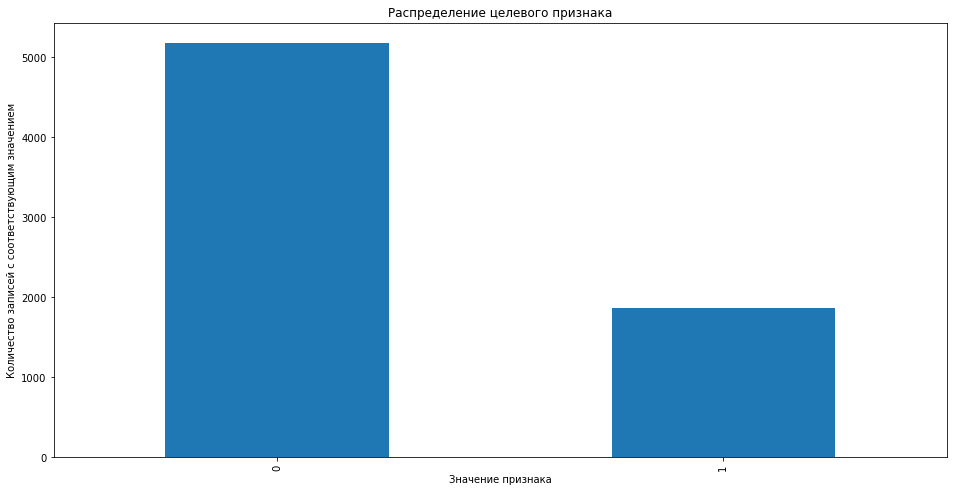

In [26]:
# Проверим баланс классов
df_target = df[target_name]
fig, ax = plt.subplots(1)
ax.set_title('Распределение целевого признака')
ax.set_xlabel('Значение признака')
ax.set_ylabel('Количество записей с соответствующим значением')
df_target.value_counts().plot(kind='bar', figsize=(16,8), ax=ax)

Имеется очевидный дисбаланс классов, при чем в пользу нужного нам значения. В связи с этим downsampling не кажется хорошим вариантом
1. Сперва попробуем upsampling
2. Если это не поможет достичь нужной метрики, попробуем балансировку на уровне моделей
3. Если и это не поможет, попробуем downsampling

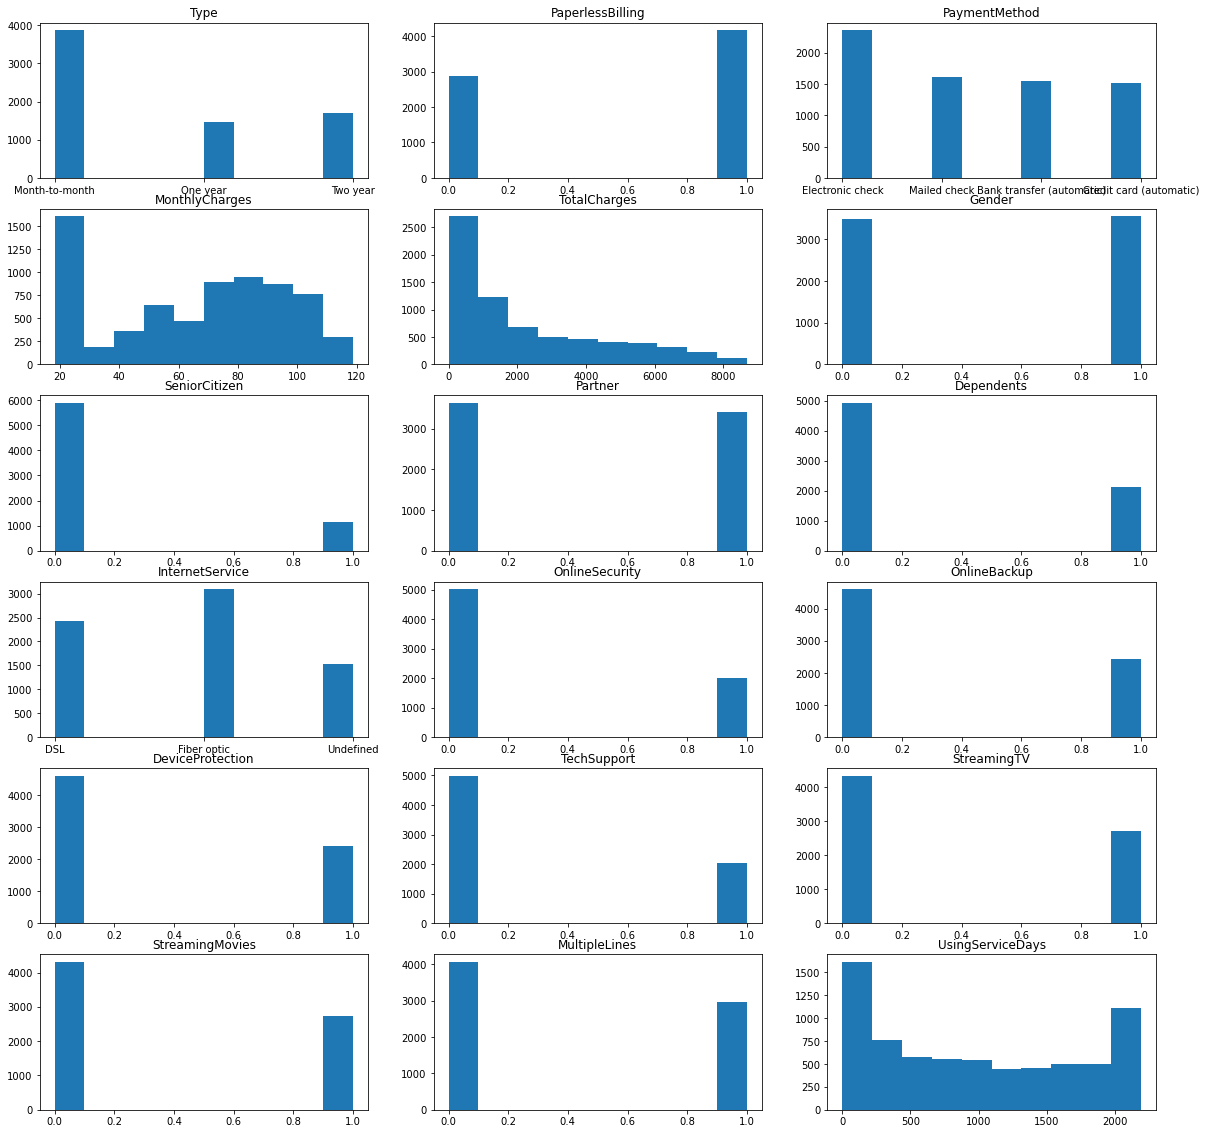

In [27]:
# Посмотрим распределение наших значений

ncols = 3
nrows = math.ceil(len(features_names) / ncols)

plt.figure(figsize=(20, 20))

counter = 0
for feature in features_names:
    counter += 1
    plt.subplot(nrows, ncols, counter)
    plt.hist(df[feature])
    plt.title(feature)

Очевидно, дополнительные услуги не пользуются популярностью. И учитывая почти одинаковые графики, если и пользуются, то по большей части у одних и тех же людей.
Также любопытно распределение общих расходов и месячных. Скорее всего, выбирающие более дорогие тарифы остаются на более редкий срок.
В остальном, распределения я бы назвал довольно равномерными, несмотря на обозначенный выше дисбаланс классов.

В связи с этим имеет смысл обратить внимание на выделение наиболее значимых признаков.

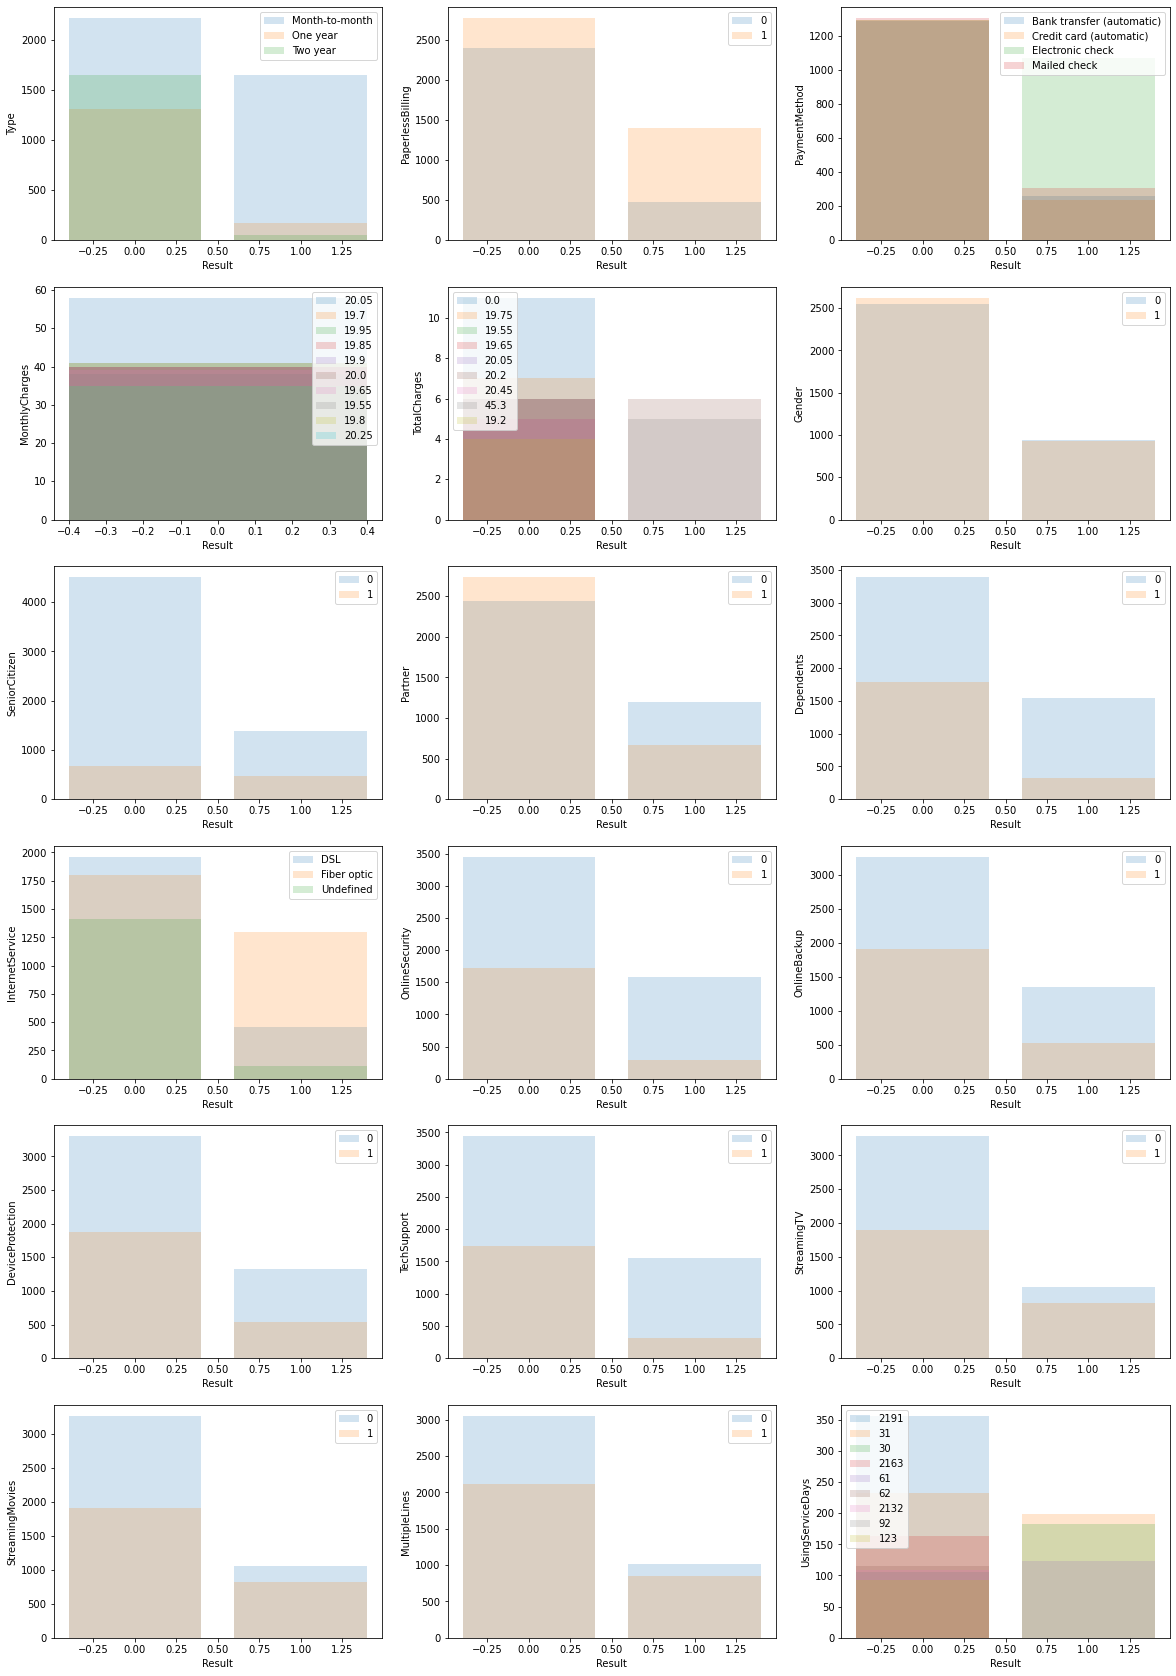

In [28]:
# Посмотрим на распределение относительно нашего целевого признака
plt.figure(figsize=(20, 30))

counter = 0
for feature in features_names:
    counter += 1
    feature_values = set(df[feature])
    
    # У числовых групп может быть вагон значений, возьмем топ-10
    if len(feature_values) > 10:
        feature_values = df[feature].value_counts().index[:10]
    
    ax = plt.subplot(nrows, ncols, counter)

    df_tmp = df.groupby([feature, target_name])[target_name].count().nlargest(10)
    df_tmp = df_tmp.unstack()

    for column in df_tmp.T.columns:
        ax.bar(df_tmp.T.index, df_tmp.T[column], alpha=0.2, label = column)

    plt.xlabel(target_name)
    plt.ylabel(feature)
    plt.legend()

- Любопытно, что среди тех, кто платит помесячно доля отказов примерно равная, а среди оплат сразу за год или за два - минимальная. Хотя это может быть связано с нехваткой данных (условно, если бы у нас были данные еще за 10 лет с такими ребятами, мб количество отказов бы выправилось)
- По графику количества дней использования видно, что наибольшие отказы связаны с использованием до двух месяцев, при этом, чем больше время пользования, тем отказов меньше
- Дополнительные услуги оказывают малое влияние на целевой показатель (пропорционально отказы почти везде одинаковы, как у тех, кто ими пользуется, так и у тех, кто нет)
- Любопытно, что среди тех, кто НЕ пользуется интернетом отказов меньше всего. На втором месте DSL (что может быть связано с тем, что его подключают там, где нет оптики и у людей может просто не быть альтернатив). А вот от оптики отказываются проще всего.

In [29]:
# Посмотрим выбросы и диаграмму размаха
df.describe()

,PaperlessBilling,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Result,UsingServiceDays
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.592219,64.761692,2279.734304,0.504756,0.162147,0.483033,0.299588,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.421837,0.265370,985.996166
std,0.491457,30.090047,2266.794470,0.500013,0.368612,0.499748,0.458110,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.493888,0.441561,747.587844
min,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,398.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,273.000000
50%,1.000000,70.350000,1394.550000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,883.000000
75%,1.000000,89.850000,3786.600000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1676.000000
max,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2191.000000


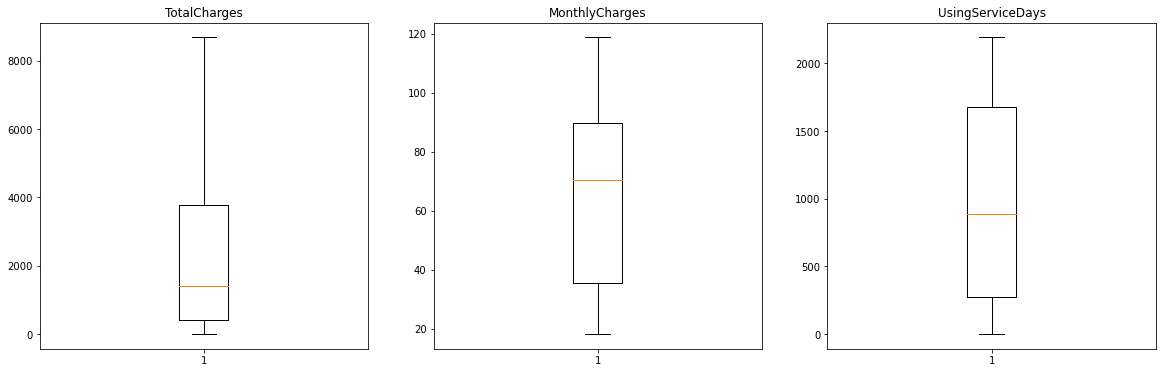

In [30]:
# Посмотрим диаграммы размаха
plt.figure(figsize=(20, 6))

counter = 0
numeric_len = len(numeric_names)
for feature in numeric_names:
    counter += 1
    plt.subplot(1, numeric_len, counter)
    plt.boxplot(df[feature])
    plt.title(feature)

В целом, что радует в этом проекте, данные довольно равномерно распределены и в целом не требуют большой обработки.

# Подготовка данных для моделей

- Посмотрим, какие признаки имеют наибольшее значение, уменьшим размерность
- Подготовка признаков (OHE, скалирование)
- Проведем балансировку

### Оценим значимость признаков

In [31]:
# Посмотрим матрицу корреляции
df_corr = df.corr()
df_corr['Result'].sort_values(ascending=False)

Result              1.000000
MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
StreamingTV         0.063228
StreamingMovies     0.061382
MultipleLines       0.040102
Gender             -0.008612
DeviceProtection   -0.066160
OnlineBackup       -0.082255
Partner            -0.150448
Dependents         -0.164221
TechSupport        -0.164674
OnlineSecurity     -0.171226
TotalCharges       -0.198324
UsingServiceDays   -0.352673
Name: Result, dtype: float64

Формально, наиболее значимыми являются количество дней и общее количество потраченных денег. При этом размер ежемесячных платежей имеет отрицательную корреляцию.

In [32]:
# Воспользуемся методом get_feature_importance у CatBoost, чтобы оценить значение признаков
# Для начала подготовим выборки и рассчитаем коэффиценты

df_features = df[features_names]
df_target = df[target_name]

features_train, features_test, target_train, target_test = train_test_split(df_features, df_target, test_size=0.2, random_state=RANDOM_STATE)

train_pool = Pool(data=features_train, label=target_train, cat_features=categories, feature_names=features_names)
v_counts = target_train.value_counts()
scale_pos_weight = v_counts[0] / v_counts[1]

scale_pos_weight

2.766042780748663

In [33]:
# Обучим нашу модель
catboost = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight, task_type="GPU", random_seed=RANDOM_STATE)
catboost.fit(train_pool)

In [34]:
# Получим значимые признаки
features_and_score = list(zip(catboost.feature_names_, catboost.get_feature_importance()))
df_score = pd.DataFrame(features_and_score)
df_score.sort_values(by=1, ascending=False)

,0,1
17,UsingServiceDays,60.586842
0,Type,11.187790
9,InternetService,11.125365
2,PaymentMethod,8.034020
1,PaperlessBilling,2.093186
14,StreamingTV,1.550107
15,StreamingMovies,1.315548
3,MonthlyCharges,1.183719
10,OnlineSecurity,0.934541
13,TechSupport,0.733398


In [35]:
# В целом, как и предполагалось, ряд признаков не влияют на результат, поэтому уменьшение размерности не должно нам помешать
# В качестве эксперимента оставим только признаки со скорингом больше 0.6

df_score.columns = ['feature_name', 'score']
features_choosen = list(df_score.query('score > 0.6')['feature_name'])
features_choosen

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'InternetService',
 'OnlineSecurity',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'UsingServiceDays']

### Проведем балансировку классов и подготовку признаков

Разобьём выборку на тестовую и обучающую.

НО!

Поскольку у нас есть дисбаланс классов, не совсем правильно сразу проводить oversampling. При этом случайное разбиение при дисбалансе не учитывает то, что малое количество целевого класса может попасть (а значит, модели будет сложнее пройти тест на адекватность). Фактически, нам нужно провести стратификацию. Возможно, это помешает достичь лучшего результата с точки зрения оценки, но модель будет точно ближе к реальности.

Поэтому правильно подготовить тестовую выборку самостоятельно по принципу:
1. Не больше 20% от общей выборки (в связи с малым количеством положительных классов)
2. В тестовой выборке должно быть 50% каждого класса

In [36]:
# Разобьём выборку на тестовую и обучающую согласно принципам обозначенным выше
total_len = df.count().iat[0]
# Нам нужно по 5% от каждого класса (пробовал больше, но возникает проблема переобучения)
part_count = round(0.05 * total_len)

columns = features_choosen + [target_name]
df_tmp = df[columns]

# Сразу применим OHE
df_tmp = pd.get_dummies(df_tmp, drop_first=True)

# Разделим 1 и 0
df_only_1 = df_tmp.query('Result == 1')
df_only_0 = df_tmp.query('Result == 0')

# Перемешаем выборки
df_only_1 = df_only_1.sample(frac=1, random_state=RANDOM_STATE)
df_only_0 = df_only_0.sample(frac=1, random_state=RANDOM_STATE)

df_test_1, df_train_1 = df_only_1[:part_count], df_only_1[part_count:]
df_test_0, df_train_0 = df_only_0[:part_count], df_only_0[part_count:]

df_train = pd.concat([df_train_1, df_train_0])
df_test = pd.concat([df_test_1, df_test_0])

# Проверим, что наша задумка удалась
df_test[target_name].value_counts()

0    352
1    352
Name: Result, dtype: int64

In [37]:
df_train[target_name].value_counts()

0    4822
1    1517
Name: Result, dtype: int64

In [38]:
# Сразу проведем скалирование числовых признаков
scaler = StandardScaler()
scaler.fit(df_train[numeric_names])

df_train[numeric_names] = scaler.transform(df_train[numeric_names])
df_test[numeric_names] = scaler.transform(df_test[numeric_names])

df_train[numeric_names].sample(5, random_state=RANDOM_STATE)

,TotalCharges,MonthlyCharges,UsingServiceDays
customerID,,,
0031-PVLZI,-0.984107,-1.460096,-1.181473
4816-OKWNX,1.289414,1.286358,0.697550
1465-LNTLJ,-0.761450,-0.003368,-1.016505
6933-FHBZC,-0.333406,-0.279501,-0.282868
4178-EGMON,1.619887,0.777082,1.514342


In [39]:
# Еще раз выделим целевой признак из наших данных
last_features_names = list(df_train.columns)
last_features_names.remove(target_name)

features_train = df_train[last_features_names]
target_train = df_train[target_name]

features_test = df_test[last_features_names]
target_test = df_test[target_name]

In [40]:
# Проведем балансировку
# Поскольку модели лучше учатся при соотношении 50 на 50, для начала вычислим коэффицент (насколько больше у нас отрицательных значений)
coef = target_train[target_train == 1].count() / target_train[target_train == 0].count()
coef

0.31459975114060557

In [41]:
# Проведем апсемплинг
def upsample(features, target, coef):
    if (coef > 1):
        print('Положительных значений больше чем отрицательных, увеличение не требуется, ', coef)
        return features, target
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = round(1 / coef)
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, coef)
target_upsampled.value_counts()

0    4822
1    4551
Name: Result, dtype: int64

In [42]:
# Посмотрим, что в итоге получилось
features_upsampled.count().iat[0], target_upsampled.count()

(9373, 9373)

In [43]:
features_test.count().iat[0], target_test.count()

(704, 704)

In [44]:
target_upsampled.value_counts()

0    4822
1    4551
Name: Result, dtype: int64

In [45]:
target_test.value_counts()

0    352
1    352
Name: Result, dtype: int64

# Обучение моделей

### Логистическая регрессия

In [46]:
# Опробуем логистическую регрессию

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
model = LogisticRegression(solver='lbfgs', penalty='l2')
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_upsampled, target_upsampled)
grid.best_params_

{'C': 1000}

In [47]:
model = LogisticRegression(solver='lbfgs', penalty='l2', C=100)
model.fit(features_upsampled, target_upsampled)
#predicted_test = model.predict(features_test)
predict_true_probalities = model.predict_proba(features_test)[:, 1]
roc_auc_score(target_test, predict_true_probalities)

0.8683456547004132

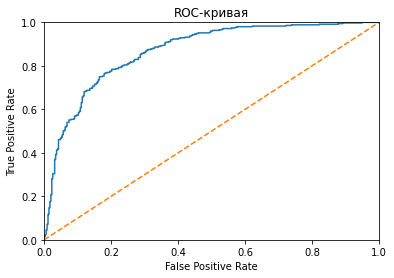

In [48]:
def make_roc_curve(target_test, predicted_test):
    fpr, tpr, thresholds = roc_curve(target_test, predicted_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    
make_roc_curve(target_test, predict_true_probalities)

Не самый плохой результат, учитывая равномерность и неизвестность тестовой выборки, но далёк от идеала и нужных нам значений.

### Случайный лес

In [49]:
%%time

param_grid = {
    'max_depth': [2, 10, 20, 30, 40],
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(2, 11, 2),
    'n_estimators': range(50, 101, 10)
}

model = RandomForestClassifier(random_state=RANDOM_STATE)

grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
#grid.fit(features_upsampled, target_upsampled)
#grid.best_params_

# Т.к. тренажер часто тупит, закомментировал момент подбора
# Лучшие найденные параметры:
# {'max_depth': 30,
# 'min_samples_leaf': 2,
# 'min_samples_split': 2,
# 'n_estimators': 90}

Wall time: 0 ns


In [50]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=30, min_samples_leaf=2, n_estimators=90, min_samples_split=2)
model.fit(features_upsampled, target_upsampled)
#predicted_test = model.predict(features_test)
predict_true_probalities = model.predict_proba(features_test)[:, 1]
roc_auc_score(target_test, predict_true_probalities)

0.862853499483471

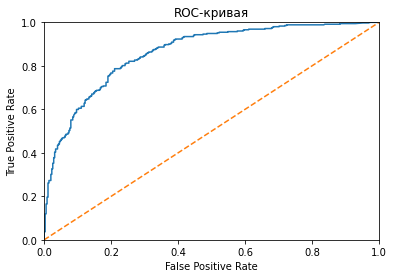

In [51]:
make_roc_curve(target_test, predict_true_probalities)

Случайному лесу прям не очень на такой разбитой выборке, до целевого показателя ещё очень далеко

### Дерево решений

In [52]:
%%time

param_grid = {
    "criterion":["gini", "entropy"],
    "max_depth": (2, 41, 2),
    "min_samples_split": range(2, 21, 2),
    "min_samples_leaf": range(2, 11, 2)
}

model = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
#grid.fit(features_upsampled, target_upsampled)
#grid.best_params_

# Т.к. тренажер часто тупит, закомментировал момент подбора
# Лучшие найденные параметры:
# {'criterion': 'entropy',
# 'max_depth': 41,
# 'min_samples_leaf': 2,
# 'min_samples_split': 2}

Wall time: 1 ms


In [53]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='entropy', max_depth=41, min_samples_split=2, min_samples_leaf=2)
model.fit(features_upsampled, target_upsampled)
#predicted_test = model.predict(features_test)
predict_true_probalities = model.predict_proba(features_test)[:, 1]
roc_auc_score(target_test, predict_true_probalities)

0.7370908122417354

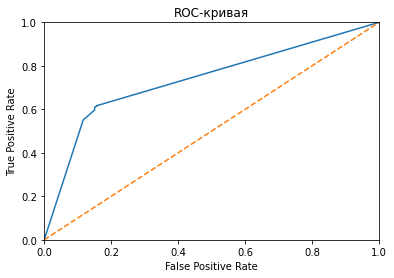

In [54]:
make_roc_curve(target_test, predict_true_probalities)

Дерево решений также очень далеко от нужного результата

### CatBoost

In [55]:
%%time

# Попробуем катбуст с параметрами по умолчанию

# Подготовим параметры
feature_names = list(features_upsampled.columns)
cat_features = list(set(feature_names) - set(numeric_names))

train_pool = Pool(data=features_upsampled, label=target_upsampled, cat_features=cat_features, feature_names=feature_names)
test_pool = Pool(data=features_test, label=target_test, cat_features=cat_features, feature_names=feature_names)

catboost = CatBoostClassifier(verbose=0, task_type="GPU", devices='0:1', random_seed=RANDOM_STATE)
catboost.fit(train_pool)

#predicted_test = catboost.predict(test_pool)
predict_true_probalities = model.predict_proba(features_test)[:, 1]

roc_auc_score(target_test, predict_true_probalities)

Wall time: 27.4 s


0.7370908122417354

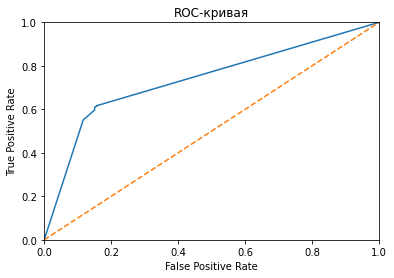

In [56]:
make_roc_curve(target_test, predict_true_probalities)

In [57]:
%%time

# Т.к. целевой метрики достичь не удалось, но катбуст показал лучший результат, попробуем его потюнить
param_grid = {
    'iterations':[100, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': range(6, 11, 2), # рекомендуемые значения, согласно https://catboost.ai/docs/concepts/parameter-tuning.html#trees-number__overfitting-detection-settings
    'l2_leaf_reg': range(3, 10, 2),
    'border_count':[128], # оставил только рекомендованное значение для GPU
}

#model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', task_type="GPU", devices='0:1', random_seed=RANDOM_STATE, thread_count=-1)
#gs_result = model.grid_search(param_grid, train_pool, verbose=0, train_size=0.8, plot=False, partition_random_seed=RANDOM_STATE)
#gs_result['params']

# Т.к. тренажер часто тупит, закомментировал момент подбора
# Лучшие найденные параметры:
#{'border_count': 128,
# 'depth': 10,
# 'l2_leaf_reg': 9,
# 'iterations': 1000,
# 'learning_rate': 0.3}

Wall time: 0 ns


In [58]:
# Для истории, неплохой результат с укороченной версией проверки на малых итерациях

#  {'depth': 10,
# 'l2_leaf_reg': 5,
#  'iterations': 100,
#  'learning_rate': 0.5}

model = CatBoostClassifier(loss_function='Logloss', depth=10, l2_leaf_reg=5, eval_metric='AUC', iterations=100, learning_rate=0.5, task_type="GPU", devices='0:1', random_seed=RANDOM_STATE, thread_count=-1, border_count=128, verbose=0)
model.fit(train_pool, eval_set = [(features_test, target_test)], use_best_model=True)
#predicted_test = model.predict(test_pool)
predicted_proba = model.predict_proba(test_pool)[:, 1]
roc_auc_score(target_test, predicted_proba)

0.9027916774276858

In [59]:
# Версия после улучшения

#{'border_count': 128,
# 'depth': 10,
# 'l2_leaf_reg': 9,
# 'iterations': 1000,
# 'learning_rate': 0.3}
model = CatBoostClassifier(loss_function='Logloss', depth=10, l2_leaf_reg=9, eval_metric='AUC', iterations=1000, learning_rate=0.3, task_type="GPU", devices='0:1', random_seed=RANDOM_STATE, thread_count=-1, border_count=128, verbose=0)
model.fit(train_pool, eval_set = [(features_test, target_test)], use_best_model=True)
#predicted_test = model.predict(test_pool)
predicted_proba = model.predict_proba(test_pool)[:, 1]
roc_auc_score(target_test, predicted_proba)

0.9335090069731407

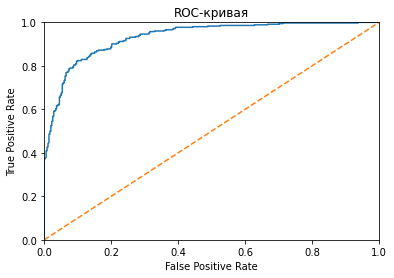

In [60]:
make_roc_curve(target_test, predicted_proba)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'PaperlessBilling'),
  Text(1, 0, 'MonthlyCharges'),
  Text(2, 0, 'TotalCharges'),
  Text(3, 0, 'OnlineSecurity'),
  Text(4, 0, 'TechSupport'),
  Text(5, 0, 'StreamingTV'),
  Text(6, 0, 'StreamingMovies'),
  Text(7, 0, 'UsingServiceDays'),
  Text(8, 0, 'Type_One year'),
  Text(9, 0, 'Type_Two year'),
  Text(10, 0, 'PaymentMethod_Credit card (automatic)'),
  Text(11, 0, 'PaymentMethod_Electronic check'),
  Text(12, 0, 'PaymentMethod_Mailed check'),
  Text(13, 0, 'InternetService_Fiber optic'),
  Text(14, 0, 'InternetService_Undefined')])

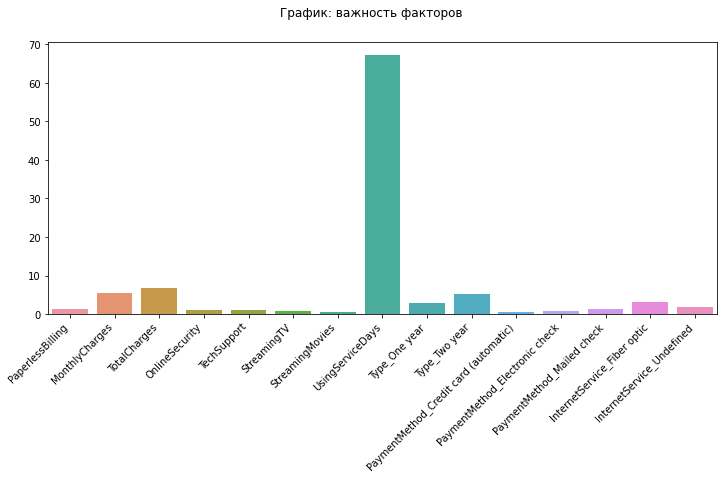

In [61]:
# По совету ревьювера добавляю график значимых признаков для демонстрации бизнесу
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle('График: важность факторов')
sns.barplot(y=model.feature_importances_, x=features_train.columns, ax=ax)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light')

# Вывод

- Мы объединили исходные данные, обработали пропуски и ошибки. Дополнительно выделили количество дней использования услугой. На самом деле, изначально я пробовал выделить месяца, но они показали себя хуже. Вероятно это связано с тем, что признак является ключевым для определения оттока клиентов, а месяца одинаково идентифицируют всех недавних клиентов. Поэтому дни оказались более удачным выбором.
- Мы провели исследование и общую подготовку данных. Из любопытного:
    - Среди тех, кто платит помесячно доля отказов примерно равная, а среди оплат сразу за год или за два - минимальная
    - По графику количества дней использования видно, что наибольшие отказы связаны с использованием до двух месяцев, при этом, чем больше время пользования, тем отказов меньше. Компании явно стоит предусмотреть некоторые акции, которые будут стимулировать пользователя оставаться в течении трех и более месяцев.
    - Также, общее количество потраченных денег хорошо влияет на отток, что подтверждает необходимость в том, чтобы сохранить клиента в самом начале (чтобы он успел и больше потратить)
    - Дополнительные услуги оказывают малое влияние на целевой показатель (пропорционально отказы почти везде одинаковы, как у тех, кто ими пользуется, так и у тех, кто нет)
    - Любопытно, что среди тех, кто НЕ пользуется интернетом отказов меньше всего. На втором месте DSL, что может быть связано с тем, что его подключают там, где нет оптики и у людей может просто не быть альтернатив.
    - Дополнительные услуги оказывают наименьшее влияние. Хотя, учитывая, что они также определяют суммарные затраты пользователя, которые влияют на отток, с ними также нужно работать. Однако, имеет смысл держать в голове, что высокие ежемесячные затраты, особенно на начальном этапе, могут стимулировать отток.
- Мы обработали и подготовили наши данные для моделей. Для большей честности модели была использована стратифицированная выборка, а также были оставлены только наиболее значимые признаки. К самим данным мы применили скалирование (для числовых признаков), OHE (для категориальных), а также искусственно увеличили количество наших данных.
- Мы попробовали и обучили разные модели. Полученные результаты:

| Название модели         | ROC_AUC         |
|:----------------------- | ---------------:|
| Логистическая регрессия | 86,83%          |
| Дерево решений          | 73,71%          |
| Случайный лес           | 86,29%          |
| CatBoost                | 93,35%          |

- По итогу, победила модель CatBoost благодаря которой нам удалось преодолеть заданный задачей максимальный порог (88%). И довольно любопытно, что логистическая регрессия оказалась на втором месте.

# Отчёт по задаче

На самом деле, на большинство вопросов уже есть ответ в выводе, тем не менее, уточню ряд моментов.

- Все пункты плана были выполнены, ключевые шаги в решении задачи полностью соответствуют ему
- В процессе работы были также не самые удачные решения. Например, изначально вместо количества дней, что пользователь пользуется услугами, я выделил месяцы, в результате они показали себя хуже. 
- Нам удалось достичь показателя 93,35%